<h1><center>

![](https://i.imgur.com/jrRGMfx.png)

AI PRACTITIONER COURSE 

ASSIGNMENT - SESSION 9 - Recurrent Neural Network

**&copy; 2020 VTCA-COTAI. Internal Use Only.**

</center></h1>

# 9.1 Theory Review

## 9.1.1 [2 Point] RNN equations
- Draw diagram as in slide 10 and write down equations of vanila RNN for 3 timesteps with inputs $\mathbf{x}_t$, 1 hidden layer $\mathbf{h}_t$, and 1 softmax layer for output $\mathbf{\hat{y}}_t$.
- Vẽ lưu đồ như ở slide 10 và viết công thức cụ thể của RNN cơ bản cho 1 chuỗi 3 cặp input-output $\{(\mathbf{x}_t, \mathbf{y}_t)\}_{t=1}^3$, với 1 lớp ẩn $\mathbf{h}_t$, 1 lớp softmax phân loại đầu ra $\mathbf{\hat{y}}_t$. 

**Answers**:
- $\mathbf{{h}}_t = \gamma(W_h\mathbf{h}_{t-1} + W_x\mathbf{x}_{t} + \mathbf{b}_h)$
- $\mathbf{\hat{y}}_t = s(W_y\mathbf{h}_t + \mathbf{b}_y)$

## 9.1.2 [1 Point] Weight-sharing in time
- What is weight-sharing in RNN and why is it useful?
- Chia sẻ tham số theo thời gian trong RNN là gì và vì sao nó có ích?

**Answers**:
- When we *unroll* an RNN in time, we have a cascade of FNNs (feed-forward) with exactly *same* set of parameters $(W_h, W_x, W_y, b_h, b_y)$. This is called "weight-sharing in time" and it helps reduce the number of learning parameters, making RNNs very efficient models for training.
- Khi ta "trải" 1 mạng hồi quy RNN theo thời gian, ta được 1 chuỗi các mạng lan truyền thuận nối tiếp nhau, và các mạng này *có cùng bộ tham số*. Đây gọi là "chia sẻ tham số theo thời gian", giúp giảm số tham số cần phải huấn luyện, làm cho mô hình học tốt hơn.

## 9.1.3 [1 Point] BPTT training
- Explain briefly gradient-based training method for RNN.
- Giải thích ngắn gọn (tự viết lại) phương pháp huấn luyện RNN theo đạo hàm.

**Answers**:
- Gradient-based method: backpropagation through time (BPTT) 
  1. Treat the unfolded network as a big feed-forward network. 
  2. The whole input sequence is given to the FFNN. 
  3. The weight updates are computed for each copy in the unfolded network using the usual back-propagation method.
  4. All the updates are then summed (or averaged) and then applied to the RNN (shared) weights.
- Lan truyền ngược thời gian:
  1. "Trải" RNN ra thành 1 chuỗi kết nối các mạng lan truyền thuận
  2. Chuỗi input/output được đưa vào từng mạng
  3. Đạo hàm được tính cho từng mạng bằng phương pháp lan truyền ngược
  4. Vì bộ trọng số *được chia sẻ* nên ta tổng các thay đổi lại hoặc tính trung bình, rồi cập nhật.



# 9.2 [2 Points] Coding

Ở homework này, chúng ta sẽ thực hành dùng mạng RNN để dự đoán nhiệt độ cho ngày tiếp theo.

Dataset được download từ link này https://climexp.knmi.nl/data/tdaily_cet.dat. Bao gồm nhiệt độ trung bình mỗi ngày ở nước Anh, thu thập từ ngày 01-01-1772 đến 11-11-2020.

Cell bên dưới sẽ download dữ liệu về dưới dạng .txt


In [ ]:
!wget --no-check-certificate https://climexp.knmi.nl/data/tdaily_cet.dat -O /content/tdaily_cet.dat.txt

--2020-12-08 08:27:32--  https://climexp.knmi.nl/data/tdaily_cet.dat
Resolving climexp.knmi.nl (climexp.knmi.nl)... 145.100.58.44
Connecting to climexp.knmi.nl (climexp.knmi.nl)|145.100.58.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182489 (2.1M)
Saving to: ‘/content/tdaily_cet.dat.txt’

/content/tdaily_cet 100%[===================>]   2.08M  3.64MB/s    in 0.6s    

2020-12-08 08:27:33 (3.64 MB/s) - ‘/content/tdaily_cet.dat.txt’ saved [2182489/2182489]



**Import các thư viện cần thiết**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Hàm để đọc dữ liệu từ file .txt đã download**

In [ ]:
def get_data():  
  data_file = "/content/tdaily_cet.dat.txt"
  f = open(data_file)
  data = f.read()
  # print(data)
  f.close()
  lines = data.split('\n')
  temperatures=[]
  day = []
  for line in lines:
      if line and line.find('#') == -1:
          linedata = line.split()
          day.append(linedata[0])
          # print(linedata[1])
          temperatures.append(float(linedata[1]))
  day = np.asarray(day)
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype="int")

  return time, series, day


Các biến trả ra của hàm get_data gồm
- time: kiểu dữ liệu list-int, đại diện cho số ngày (từ ``0`` đến ``90895``)
- day: kiểu dữ liệu list-string, đại diện cho ngày thực tế (từ ``17720101`` đến ``20201111``)
- series: kiểu dữ liệu list-float, đại diện cho nhiệt độ trung bình mỗi ngày

In [ ]:
time, series, day = get_data()
print('Length of time:',len(time))
print('Length of series:',len(series))
print('Length of day:',len(day))

Length of time: 90896
Length of series: 90896
Length of day: 90896


**Chia train test**

Ta lấy ra dữ liệu của 60000 ngày đầu tiên làm train, 10000 ngày tiếp theo làm validation và toàn bộ ngày còn lại làm test

In [ ]:
split_train_time = 60000
split_val_time = split_train_time + 10000
time_train = time[:split_train_time]
x_train = series[:split_train_time]
time_val = time[split_train_time:split_val_time]
x_val = series[split_train_time:split_val_time]
time_test = time[split_val_time:]
x_test = series[split_val_time:]

**Standardization**

Tính giá trị **trung bình** và **độ lệch chuẩn** trên tập train. Sau đó thực hiện Standardization trên cả tập Train và tập Test

In [ ]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train-=mean
x_train/=std

x_val-=mean
x_val/=std

x_test-=mean
x_test/=std

**Visualize data**

In [ ]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end])
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

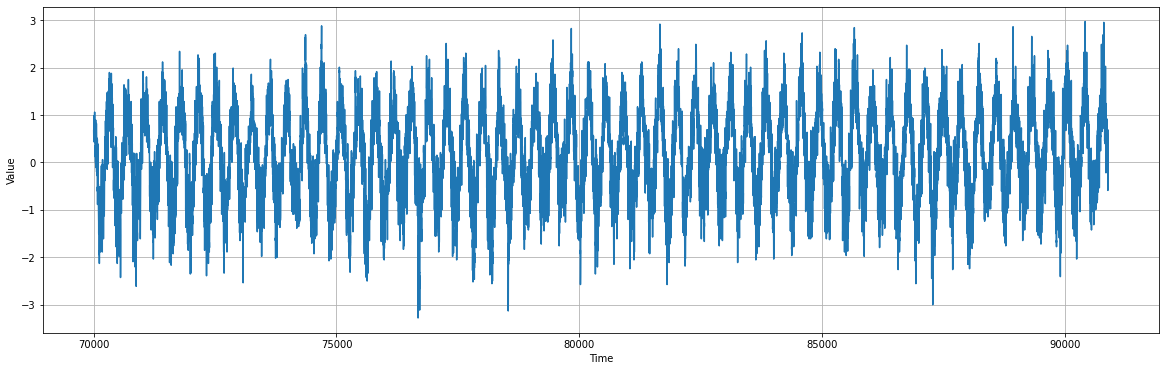

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(time_test, x_test)

Hình trên là toàn bộ dữ liệu trong tập Test (12896 ngày)

Ta cần viết hàm để chia tập dữ liệu lớn này thành nhiều mẫu nhỏ, mỗi mẫu gồm ``n`` time-step (ví dụ với bài lab trên lớp sẽ là 8000 mẫu cho tập train, 50 time-step mỗi mẫu)

Các tham số truyền vào hàm ``windowed_dataset`` cần quan tâm gồm:
- series: Bộ dữ liệu cần chia nhỏ.
- window_size: time_step cho từng mẫu

Ở đây chúng ta dùng class ``tf.data.Dataset`` của Tensorflow 2 để lưu trữ dữ liệu.

**Lưu ý:** Mỗi framework Deep Learning đều có 1 class ``Dataset`` của riêng chúng với chức năng tương tự nhau và mang đến rất nhiều ưu điểm khi thực hiện tiền xử lý dữ liệu. Do đó khuyến khích học viên tìm hiểu thêm về class này để có thể tự sử dụng.

**Chia dữ liệu thành từng cụm nhỏ**

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Ta khai báo window_size = 60, tương ứng với lấy dữ liệu của mỗi 60 ngày thành 1 cụm (sample) để train và test.

Sau đó gọi hàm ``windowed_dataset`` truyền vào ``x_train`` và ``x_test``

In [ ]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_val, window_size, batch_size, shuffle_buffer_size)
test_dataset = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

**Lưu ý:** khi gọi hàm ``fit``, ta làm như sau

```
model.fit(train_dataset, validation_data=val_dataset)
```

## 9.2.1 [2 Points] Xây dựng và huấn luyện mô hình

**TODOs**
1. Xây dựng và huấn luyện mô hình để dự báo nhiệt độ, học viên tự do sử dụng các layer sau ``SimpleRNN, GRU, LSTM``
1. Bài toán này yêu cầu dự báo giá trị của 1 điểm dữ liệu mới, tương ứng với phần đầu của bài lab trên lớp.
1. Sử dụng ``input_shape=[None, 1]``, None nghĩa là có thể sử dụng số time-step (window_size) bất kì. 
1. Đối với hàm loss, có thể truyền vào ``tf.keras.losses.Huber()`` hoặc ``'mse'``
1. Lưu ý: cách sử dụng tham số ``return_sequences=True``
1. Đối với mạng RNN/GRU/LSTM, nếu model bị overfit, ta có thể áp dụng **Dropout** bằng cách truyền vào 2 tham số ``dropout=0.1`` và ``recurrent_dropout=0.1``. Ví dụ:
```
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
```
1. Khi gọi hàm ``fit`` nhớ lấy ra biến ``history``

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)



model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.GRU(100), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train_dataset, epochs=2,  verbose=1, validation_data=val_dataset)

**Vẽ Learning Curve**

In [ ]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.figure()
plt.show()

**Inference**

Hàm để forecast cho trên tập test

In [ ]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
forecast = model_forecast(model, x_test, window_size)[:,0]

Ở đây ta vẽ 2 biểu đồ là dự báo trên toàn bộ tập Test và dự báo trên 60 ngày cuối cùng

**Chú ý** do lượng dữ liệu trên tập test không chia đều cho 60 (window_size) nên 1 vài điểm dữ liệu sẽ bị mất, do đó ta chỉ tính trong khoảng ``time_test[:forecast.shape[0]]``

In [ ]:
# Forecast on whole test set
plt.figure(figsize=(20,6))
plot_series(time_test[:forecast.shape[0]], x_test[:forecast.shape[0]])
plot_series(time_test[:forecast.shape[0]], forecast)
plt.show()
# Forecast on last 60 days
plt.figure(figsize=(20,6))
plot_series(time_test[-window_size:], x_test[-window_size:])
plot_series(time_test[-window_size:], forecast[-window_size:])
plt.show()